In [16]:
# Imports
import numpy as np
import pandas as pd

%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from obspy import read
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

In [17]:
# Constants
victoria_lat = 48.4284  # coordinates of Victoria, BC, general center location where we will look
victoria_lon = -123.3656
day0 = np.datetime64('2009-08-01 00:00:00')

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_70104/3875100503.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  trm = pd.read_csv("data/tremor_events-2009-08-06T00_00_00-2025-03-19T23_59_59.csv")


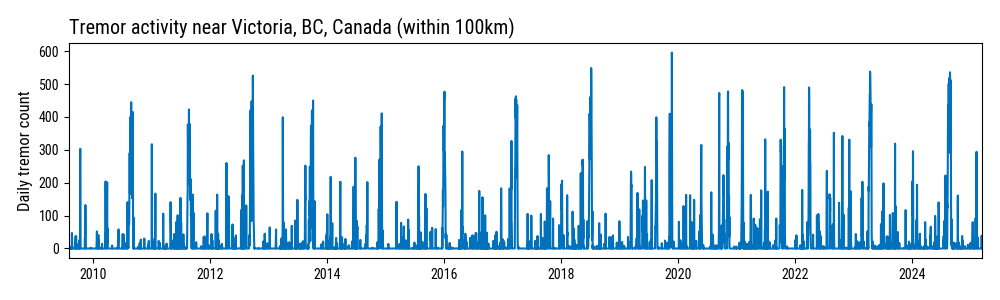

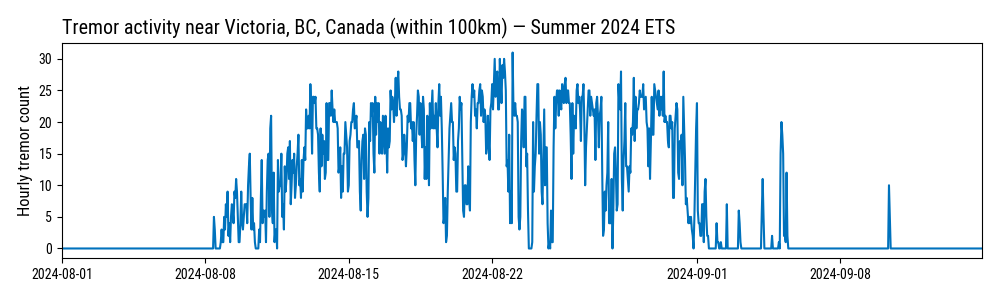

In [ ]:
# Load tremor
# I’ve downloaded the tremor events from the PNSN website: https://pnsn.org/tremor
trm = pd.read_csv("data/tremor_events-2009-08-06T00_00_00-2025-03-19T23_59_59.csv")

trm["date"] = pd.to_datetime(trm["starttime"])
trm["day"] = (trm["date"] - day0) / np.timedelta64(1, 'D')

# Select tremor events a certain radius below the station
radius = 100  # in km
dx = (trm.lon - victoria_lon) * 111.32 * np.cos(np.radians(trm.lat.mean()))
dy = (trm.lat - victoria_lat) * 111.32

dist = np.sqrt(dx**2 + dy**2)

trm_vic = trm.copy()
trm_vic = trm_vic[dist < radius]

# Show activity
trm_count, count_time = np.histogram(trm_vic.day, bins=np.arange(0, trm.day.max(), 1))  # count of daily tremor
count_time = count_time[:-1] + 0.5
count_date = day0 + count_time * np.timedelta64(1, "D")

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_ylabel("Daily tremor count")
ax.set_title(f"Tremor activity near Victoria, BC, Canada (within {radius:.0f}km)", loc='left')

ax.plot(count_date, trm_count, label="Tremor count")

ax.set_xlim(count_date[0], count_date[-1])

plt.tight_layout()
plt.show()

# Show one episode
interval = (np.datetime64('2024-08-01'), np.datetime64('2024-09-15'))
in_interval = (trm_vic.date > interval[0]) & (trm_vic.date < interval[1])
trm_count_hf, count_time_hf = np.histogram(trm_vic[in_interval].day, bins=np.arange((interval[0] - day0)/np.timedelta64(1, "D"), (interval[1] - day0)/np.timedelta64(1, "D"), 1/24))  # count of hourly tremor
count_time_hf = count_time_hf[:-1] + 0.5/24
count_date_hf = day0 + count_time_hf*24*np.timedelta64(1, "h")

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_ylabel("Hourly tremor count")
ax.set_title(f"Tremor activity near Victoria, BC, Canada (within {radius:.0f}km) — Summer 2024 ETS", loc='left')

ax.plot(count_date_hf, trm_count_hf, label="Tremor count")

ax.set_xlim(count_date_hf[0], count_date_hf[-1])

plt.tight_layout()
plt.show()

In [19]:
# List stations that we can use to investigate the summer 2024 ETS below Vancouver Island
client = Client("IRIS")
inventory = client.get_stations(longitude=-123.3656, latitude=48.4284, maxradius=1., network="*", channel="HH*", level="channel", starttime=UTCDateTime("2024-08-01"), endtime=UTCDateTime("2024-09-15"))

# Print stations
for network in inventory:
    for station in network:
        print(f"{network.code}.{station.code} ({network.start_date} - {network.end_date})")

CN.BOIB (1975-01-01T00:00:00.000000Z - None)
CN.CLRS (1975-01-01T00:00:00.000000Z - None)
CN.GOBB (1975-01-01T00:00:00.000000Z - None)
CN.NLLB (1975-01-01T00:00:00.000000Z - None)
CN.PGC (1975-01-01T00:00:00.000000Z - None)
CN.PTRF (1975-01-01T00:00:00.000000Z - None)
CN.QEPB (1975-01-01T00:00:00.000000Z - None)
CN.SYMB (1975-01-01T00:00:00.000000Z - None)
CN.VGZ (1975-01-01T00:00:00.000000Z - None)
GS.EVER1 (1980-01-01T00:00:00.000000Z - None)
GS.EVER3 (1980-01-01T00:00:00.000000Z - None)
GS.EVER4 (1980-01-01T00:00:00.000000Z - None)
GS.EVER6 (1980-01-01T00:00:00.000000Z - None)
GS.EVER7 (1980-01-01T00:00:00.000000Z - None)
GS.EVER8 (1980-01-01T00:00:00.000000Z - None)
PQ.ALBHB (2013-01-01T00:00:00.000000Z - None)
PQ.DAOB (2013-01-01T00:00:00.000000Z - None)
PQ.JRDRB (2013-01-01T00:00:00.000000Z - None)
PQ.LHLYB (2013-01-01T00:00:00.000000Z - None)
UW.BHAM (1963-01-01T00:00:00.000000Z - None)
UW.BUCKS (1963-01-01T00:00:00.000000Z - None)
UW.CHIMA (1963-01-01T00:00:00.000000Z - None)
U

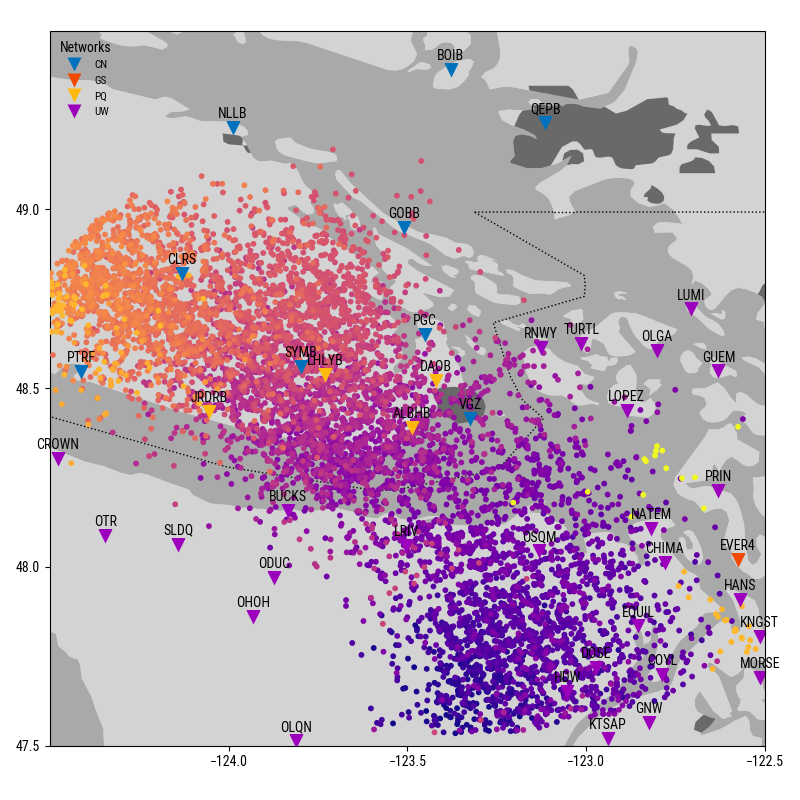

In [20]:
# Make map of stations
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-124.5, -122.5, 47.5, 49.5], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN, facecolor='darkgray')

ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'urban_areas', '10m', edgecolor='none', facecolor=to_rgba("k", .5)))

# show stations
ic = 0  # color index for networks
for network in inventory:
    c = "C{:}".format(ic)
    for station in network:
        if (station.longitude < -124.5) or (station.longitude > -122.5) or (station.latitude < 47.5) or (station.latitude > 49.5):
            continue
        # Plot station
        ax.plot(station.longitude, station.latitude, marker='v', markersize=10, mfc=c, mec="none", transform=ccrs.PlateCarree(), ls="none", zorder=10)
        ax.annotate(station.code, xy=(station.longitude, station.latitude), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), xytext=(0, 5), textcoords="offset points",
                     fontsize=10, ha="center", va="bottom", color="k", zorder=11)
    ax.plot([], [], marker='v', markersize=10, mfc=c, mec="none", transform=ccrs.PlateCarree(), label=network.code, ls="none")
    ic += 1

ax.legend(loc='upper left', fontsize=8, frameon=False, title="Networks", title_fontsize=10)

# Show tremor
in_interval = (trm_vic.date > interval[0]) & (trm_vic.date < interval[1])
ax.scatter(trm_vic[in_interval].lon, trm_vic[in_interval].lat, s=10, c=(trm_vic[in_interval].date - interval[0]) / np.timedelta64(1, "D"), cmap="plasma", transform=ccrs.PlateCarree(), zorder=9)

# Ticks etc
ax.set_xticks(np.arange(-124, -122, 0.5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(47.5, 49.5, 0.5), crs=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

In [21]:
# Choose station
net_choice = "CN"
sta_choice = "CLRS"

for network in inventory:
    for station in network:
        if station.code == sta_choice:
            station_choice = station
            print(station_choice)
            sta_lon, sta_lat = station.longitude, station.latitude
            break

# Other good choices (for that summer 2024 ETS)
# network = "CN"
# station = "PGC"

# network = "CN"
# station = "SYMB"

# network = "CN"
# station = "CLRS"

# Find yours...

Station CLRS (Cowichan Lake Research St, BC, CA)
	Station Code: CLRS
	Channel Count: 3/15 (Selected/Total)
	2014-09-11T00:00:00.000000Z - 
	Access: open 
	Latitude: 48.8203, Longitude: -124.1309, Elevation: 174.0 m
	Available Channels:
	    ..HH[ZNE]   100.0 Hz  2016-09-07 to None



/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_70104/2064522720.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  trm = pd.read_csv("data/tremor_events-2009-08-06T00_00_00-2025-03-19T23_59_59.csv")


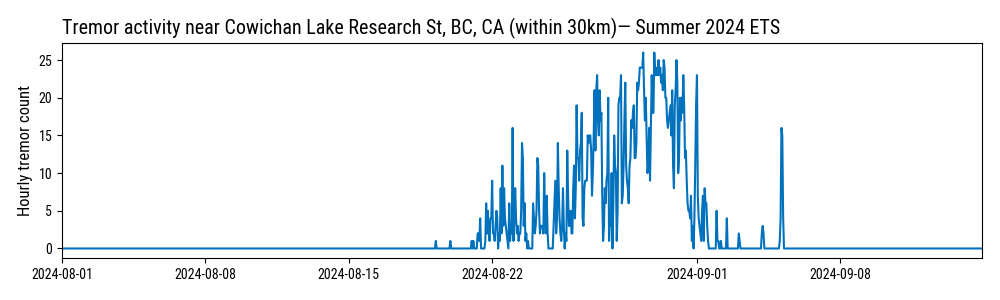

In [22]:
# Tremor around that station
trm = pd.read_csv("data/tremor_events-2009-08-06T00_00_00-2025-03-19T23_59_59.csv")

trm["date"] = pd.to_datetime(trm["starttime"])
trm["day"] = (trm["date"] - day0) / np.timedelta64(1, 'D')

# Select tremor events a certain radius below the station
radius = 30  # in km
dx = (trm.lon - sta_lon) * 111.32 * np.cos(np.radians(trm.lat.mean()))
dy = (trm.lat - sta_lat) * 111.32

dist = np.sqrt(dx**2 + dy**2)

trm_sta = trm.copy()
trm_sta = trm_sta[dist < radius]

# Show one episode
interval = (np.datetime64('2024-08-01'), np.datetime64('2024-09-15'))
in_interval = (trm_sta.date > interval[0]) & (trm_sta.date < interval[1])
trm_count_hf, count_time_hf = np.histogram(trm_sta[in_interval].day, bins=np.arange((interval[0] - day0)/np.timedelta64(1, "D"), (interval[1] - day0)/np.timedelta64(1, "D"), 1/24))  # count of hourly tremor
count_time_hf = count_time_hf[:-1] + 0.5/24
count_date_hf = day0 + count_time_hf*24*np.timedelta64(1, "h")

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_ylabel("Hourly tremor count")
ax.set_title(f"Tremor activity near {station_choice.site.name} (within {radius:.0f}km)— Summer 2024 ETS", loc='left')

ax.plot(count_date_hf, trm_count_hf, label="Tremor count")

ax.set_xlim(count_date_hf[0], count_date_hf[-1])

plt.tight_layout()
plt.show()

In [23]:
# Download one day of data from the station (check how segmented the data is over the period of interest) (if takes too much time, stop it and relaunch, it seems like it speeds up the process, but maybe it’s superstition...)
client = Client("IRIS")
st = client.get_waveforms(network=net_choice, station=station_choice.code, location="*", channel="HH*", 
                          starttime=UTCDateTime("2024-08-01T00:00:00"), endtime=UTCDateTime("2024-09-15T00:00:00"))
print(st)

6 Trace(s) in Stream:
CN.CLRS..HHE | 2024-08-01T00:00:00.000000Z - 2024-09-12T14:43:30.020000Z | 100.0 Hz, 368181003 samples
CN.CLRS..HHE | 2024-09-12T14:43:38.270000Z - 2024-09-15T00:00:00.000000Z | 100.0 Hz, 20618174 samples
CN.CLRS..HHN | 2024-08-01T00:00:00.000000Z - 2024-09-12T14:43:29.750000Z | 100.0 Hz, 368180976 samples
CN.CLRS..HHN | 2024-09-12T14:43:38.000000Z - 2024-09-15T00:00:00.000000Z | 100.0 Hz, 20618201 samples
CN.CLRS..HHZ | 2024-08-01T00:00:00.000000Z - 2024-09-12T14:43:32.260000Z | 100.0 Hz, 368181227 samples
CN.CLRS..HHZ | 2024-09-12T14:43:40.510000Z - 2024-09-15T00:00:00.000000Z | 100.0 Hz, 20617950 samples


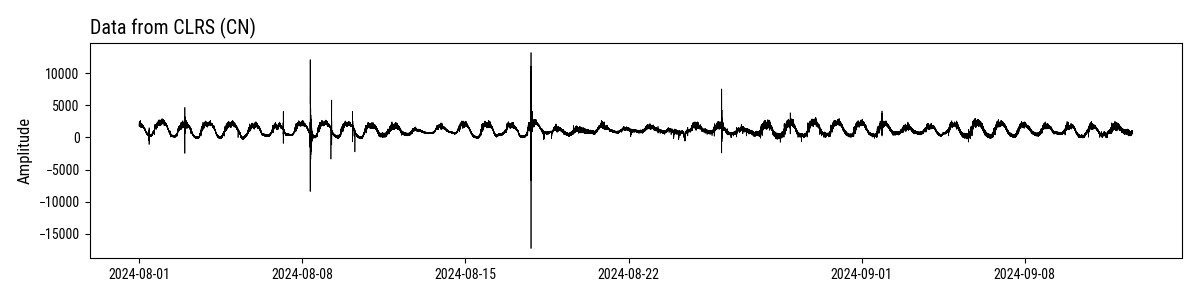

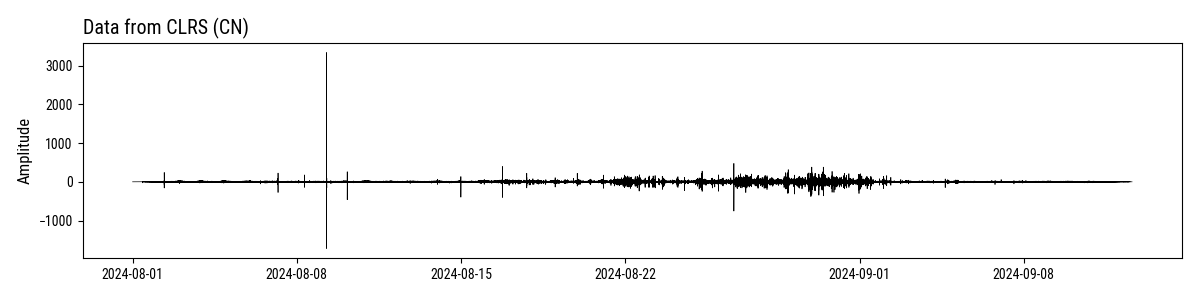

In [24]:
# Look at the data 
itrace = 2  # index of the trace we want to look at

# Show data
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(np.datetime64(st[itrace].stats.starttime.datetime) + st[itrace].times()[::100] * np.timedelta64(1, "s"), st[itrace].data[::100], color="k", lw=0.5)  # subsampled for speed
ax.set_ylabel("Amplitude")
plt.title(f"Data from {station_choice.code} ({net_choice})", loc='left')
plt.tight_layout()
plt.show()

# Filter in the tremor band
st_f = st[itrace].copy()
st_f.taper(max_percentage=0.05, type="cosine")
st_f.filter("bandpass", freqmin=1, freqmax=10, corners=4, zerophase=True)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(np.datetime64(st[itrace].stats.starttime.datetime) + st[itrace].times()[::100] * np.timedelta64(1, "s"), st_f.data[::100], color="k", lw=0.5)  # subsampled for speed
ax.set_ylabel("Amplitude")
plt.title(f"Data from {station_choice.code} ({net_choice})", loc='left')
plt.tight_layout()
plt.show()


In [25]:
# Write selected data to file
# --> Save waveform
filename = f"{net_choice}.{sta_choice}.{st[itrace].stats.channel}_{st[itrace].stats.starttime.datetime.strftime('%d%m%y')}_{st[itrace].stats.endtime.datetime.strftime('%d%m%y')}.sac"
path = "data/" + filename
print("Saving to", path)

# st[itrace].write(path, format="SAC")  # those are big files (2GB for ~1 month at 100Hz)

# --> Save station info
import pickle
pickle.dump(station_choice, open("data/" + filename.replace(".sac", ".pkl"), "wb"))  # save station info

Saving to data/CN.CLRS.HHN_010824_120924.sac
